In [1]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("..") # Adds higher directory to python modules path.

from src.data.htr_datamodule import HTRDataModule
from src.data.htr_datamodule import HTRDataset

# import v2 torchvision
from torchvision.transforms import v2
import torchvision

import src



/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:14: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to 

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
!pwd
!ls 

/workspace/notebooks


'=0.21.0'			    normalizations_dummy.ipynb
 HF_architectures.ipynb		   'ood_detection_AE (2).ipynb'
 cer_vs_predicted_cer.pdf	    ood_detection_AEs.ipynb
 clean_wandb.ipynb		    optimizers.ipynb
 example_images_rec_errors.png	    output.png
'factor_analysis copy.ipynb'	    positional_encoding.ipynb
 factor_analysis.ipynb		    preprocess_text.ipynb
 factor_analysis_FINAL.ipynb	    process_results.ipynb
 filter_synthetic.ipynb		    reconstruction_errors2.pdf
 generate_synthetic.ipynb	    reconstruction_errors_heatmap.pdf
 generate_words_2.ipynb		    reconstruction_errors_matrix_normalized.csv
 hf_architectures.py		    reconstruction_errors_matrix_raw.csv
 kl_divergence_datasets_FIXED.csv   tokenizer-wit-unidecoded-2.json
 kl_divergence_real_wit.csv	    wandb
 language_models.ipynb		    wikitext.ipynb
'lexical_similarity copy.ipynb'     words_iam
 lexical_similarity.ipynb	    words_iam.txt
 lexical_similarity_FINAL.ipynb


## Instantiate dataset for training and validation

In [4]:
# Instantiate manually the datasets
tokenizer = src.data.components.tokenizers.CharTokenizer(model_name="char_tokenizer", vocab_file="../data/vocab.txt")

# IAM dataset
with open("../data/htr_datasets/IAM/splits/train.txt", "r") as f:
  setfiles = f.read().splitlines()
  
read_data = src.data.data_utils.read_data_IAM
images_paths, words = read_data("../data/htr_datasets/IAM/IAM_lines/", "../data/htr_datasets/IAM/IAM_xml/", setfiles)
htr_dataset = HTRDataset(images_paths, words, binarize=True, transform=v2.Compose([v2.ToTensor()]))

VOCAB SIZE TOKENIZER: 94
COMPLETE VOCAB: {'[BOS]': 0, '[EOS]': 1, '[PAD]': 2, '[UNK]': 3, ' ': 4, '!': 5, '"': 6, '#': 7, '%': 8, '&': 9, "'": 10, '(': 11, ')': 12, '*': 13, '+': 14, ',': 15, '-': 16, '.': 17, '/': 18, '0': 19, '1': 20, '2': 21, '3': 22, '4': 23, '5': 24, '6': 25, '7': 26, '8': 27, '9': 28, ':': 29, ';': 30, '<': 31, '=': 32, '>': 33, '?': 34, 'A': 35, 'B': 36, 'C': 37, 'D': 38, 'E': 39, 'F': 40, 'G': 41, 'H': 42, 'I': 43, 'J': 44, 'K': 45, 'L': 46, 'M': 47, 'N': 48, 'O': 49, 'P': 50, 'Q': 51, 'R': 52, 'S': 53, 'T': 54, 'U': 55, 'V': 56, 'W': 57, 'X': 58, 'Y': 59, 'Z': 60, '[': 61, ']': 62, '_': 63, 'a': 64, 'b': 65, 'c': 66, 'd': 67, 'e': 68, 'f': 69, 'g': 70, 'h': 71, 'i': 72, 'j': 73, 'k': 74, 'l': 75, 'm': 76, 'n': 77, 'o': 78, 'p': 79, 'q': 80, 'r': 81, 's': 82, 't': 83, 'u': 84, 'v': 85, 'w': 86, 'x': 87, 'y': 88, 'z': 89, '{': 90, '}': 91, '£': 92, '€': 93}


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([transforms.ToImageTensor(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [5]:
# Generic functions for reading data and create a dataloader

def read_dataset(images_path, sequences_path, split_path, read_data, tokenizer, transform=v2.Compose([v2.ToTensor()])):
  with open(split_path, "r") as f:
    setfiles = f.read().splitlines()
  
  images_paths, words = read_data(images_path, sequences_path, setfiles)
  htr_dataset = HTRDataset(images_paths, words, binarize=True, transform=transform)

  # Create dataloader for iam
  dl = torch.utils.data.DataLoader(
    htr_dataset, 
    batch_size=64, 
    shuffle=False, 
    num_workers=4, 
    pin_memory=True,
    collate_fn=lambda batch: src.data.data_utils.collate_fn(
      batch,
      img_size=(64,1024),
      text_transform=tokenizer.prepare_text
    ),
    persistent_workers=True
  )
  return dl

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([transforms.ToImageTensor(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


## Create AE architecture

In [6]:
class Encoder(nn.Module):
  # Convolutional Encoder for HTR
  def __init__(self):
    super(Encoder, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=(3,3), padding=1)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=(3,3), padding=1)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1)
    self.conv4 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1)
    self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
    self.relu = nn.LeakyReLU()
    self.fc = nn.Linear(128*4*64, 512)
  
  def forward(self, x):
    # print(f'Encoder input shape: {x.shape}')
    x = self.relu(self.conv1(x))
    x = self.pool(x)
    # print(x.shape)
    x = self.relu(self.conv2(x))
    x = self.pool(x)
    # print(x.shape)
    x = self.relu(self.conv3(x))
    x = self.pool(x)
    # print(x.shape)
    x = self.relu(self.conv4(x))
    x = self.pool(x)
    # print(x.shape)
    x = x.view(x.size(0), -1) # Flatten operation
    # print(x.shape)
    x = self.fc(x)
    # print(x.shape)
    return x
  
  
class Decoder(nn.Module):
  # Convolutional Decoder for HTR
  def __init__(self):
    super(Decoder, self).__init__()
    self.fc = nn.Linear(512, 128*4*64)
    # Deconvolutions (transposed convolutions)
    self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=(3,3), stride=(2,2), padding=0)
    self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=(3,3), stride=(2,2), padding=1)
    self.deconv3 = nn.ConvTranspose2d(32, 16, kernel_size=(3,3), stride=(2,2), padding=1)
    self.deconv4 = nn.ConvTranspose2d(16, 3, kernel_size=(3,3), stride=(2,2), padding=1, output_padding=0)
    self.relu = nn.LeakyReLU()
    self.sigmoid = nn.Sigmoid()
    
  def forward(self, x):
    # print(f'Decoder input shape: {x.shape}')
    x = self.fc(x)
    # print(f'x.shape: {x.shape}')
    x = x.view(x.size(0), 128, 4, 64)
    # print(f'x.shape (after view): {x.shape}')
    x = self.relu(self.deconv1(x))
    # print(f'x.shape: {x.shape}')
    x = self.relu(self.deconv2(x))
    # print(f'x.shape: {x.shape}')
    x = self.relu(self.deconv3(x))
    # print(f'x.shape: {x.shape}')
    x = self.relu(self.deconv4(x))
    # print(f'x.shape: {x.shape}')
    
    x = torch.narrow(x, 2, 0, 64)
    x = torch.narrow(x, 3, 0, 1024)
    x = self.sigmoid(x)
    
    return x
  
  
class AE(nn.Module):
  # Complete Autoencoder (AE) trained to reconstruct images
  def __init__(self):
    super(AE, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()
    
  def forward(self, x):
    h = self.encoder(x)
    x = self.decoder(h)
    return x
  

  

In [7]:

# Save model checkpoint with .ckpt extension
# torch.save(model.state_dict(), '../checkpoints/autoencoder.ckpt')

In [8]:
# Load model from checkpoint``
# model = AE()
# model.load_state_dict(torch.load('../checkpoints/autoencoder.ckpt'))
# print(model)
!ls -alth checkpoints/
model = AE()
model.load_state_dict(torch.load('../checkpoints/best_ae_iam.ckpt'))
print(model)

ls: cannot access 'checkpoints/': No such file or directory


AE(
  (encoder): Encoder(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (relu): LeakyReLU(negative_slope=0.01)
    (fc): Linear(in_features=32768, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=512, out_features=32768, bias=True)
    (deconv1): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (deconv2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (deconv3): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (deconv4): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): LeakyR

/tmp/ipykernel_2231173/3351831653.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../checkpoints/best_ae_iam.ckpt'))


In [9]:
def get_reconstruction_error(model, dataset_name, data_loader, criterion):
  total_loss = 0.0
  with torch.no_grad():
    model.eval()
    model.to(device)
    for i, batch in enumerate(data_loader):
      images, targets, _ = batch
      images = images.to(device)
      outputs = (model(images) > 0.5).float()
      loss = criterion(outputs, images)
      total_loss += loss.item()
      
  return {
    "dataset": dataset_name, 
    "total_loss": total_loss,
    "reconstruction_error": total_loss / len(data_loader.dataset), 
    "n_samples": len(data_loader.dataset)
  }
  
# Get reconstruction error for IAM dataset
# reconstruction_error = get_reconstruction_error(model, "IAM", dl_train, criterion)


## Get all reconstruction errors for each dataset

In [19]:
def new_collate_fn(batch, img_size):
    images_batch, sequences_batch, padded_columns = [], [], []
    images_shapes = torch.tensor([image_sample.shape for image_sample, _ in batch]) # Get shapes of images in batch [B, C, H, W]
    all_height_ratios = (images_shapes[:, 1] / img_size[0]) # Get height ratios for all images in batch
    all_width_reescaled = images_shapes[:, 2] / all_height_ratios # Get width reescaled for all images in batch
    assert all_height_ratios.shape[0] == all_width_reescaled.shape[0], 'All height ratios and all width reescaled must have the same length'
    max_width = img_size[1] # Get max width ratio

    for i, (image_sample, _) in enumerate(batch):
      if i == 0:
        images_batch = torch.ones(len(batch), 3, img_size[0], max_width) # Reescaled height and width and white background
      
      # Resize image to fixed height
      height, width = img_size[0], all_width_reescaled[i].int()

      if all_width_reescaled[i] > max_width:
        width = max_width

      image_resized_height = torchvision.transforms.Resize((height, width), antialias=True)(image_sample)
      images_batch[i, :, :, :image_resized_height.shape[2]] = image_resized_height 

    
    return images_batch

## Convolutional Autoencoder for each dataset (Anomaly Detection, AD)

In [10]:
# Generic functions for reading data and create a dataloader

def read_dataset(images_path, sequences_path, split_path, read_data, tokenizer, transform=v2.Compose([v2.ToTensor()])):
  with open(split_path, "r") as f:
    setfiles = f.read().splitlines()
  
  images_paths, words = read_data(images_path, sequences_path, setfiles)
  htr_dataset = HTRDataset(images_paths, words, binarize=True, transform=transform)

  # Create dataloader for iam
  dl = torch.utils.data.DataLoader(
    htr_dataset, 
    batch_size=64, 
    shuffle=False, 
    num_workers=16, 
    pin_memory=True,
    # collate_fn=lambda batch: src.data.data_utils.collate_fn(
    collate_fn=lambda batch: new_collate_fn(
      batch,
      img_size=(64,1024),
    ),
    persistent_workers=True
  )
  return dl

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([transforms.ToImageTensor(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [11]:
tokenizer = src.data.components.tokenizers.CharTokenizer(model_name="char_tokenizer", vocab_file="../data/vocab.txt")

transforms_train = v2.Compose(
  [
    torchvision.transforms.v2.RandomApply([torchvision.transforms.v2.ElasticTransform(5.0, 5.0)], p=0.5),
    torchvision.transforms.v2.RandomApply([torchvision.transforms.v2.RandomAffine(degrees=1, translate=(0.01, 0.05), shear=[-1, 1, -1, 1], fill=255)], p=0.5),
    torchvision.transforms.v2.RandomApply([torchvision.transforms.v2.RandomPerspective(distortion_scale=0.1, p=1.0, fill=255)], p=0.5),
    torchvision.transforms.v2.ToTensor()
  ]
)


VOCAB SIZE TOKENIZER: 94
COMPLETE VOCAB: {'[BOS]': 0, '[EOS]': 1, '[PAD]': 2, '[UNK]': 3, ' ': 4, '!': 5, '"': 6, '#': 7, '%': 8, '&': 9, "'": 10, '(': 11, ')': 12, '*': 13, '+': 14, ',': 15, '-': 16, '.': 17, '/': 18, '0': 19, '1': 20, '2': 21, '3': 22, '4': 23, '5': 24, '6': 25, '7': 26, '8': 27, '9': 28, ':': 29, ';': 30, '<': 31, '=': 32, '>': 33, '?': 34, 'A': 35, 'B': 36, 'C': 37, 'D': 38, 'E': 39, 'F': 40, 'G': 41, 'H': 42, 'I': 43, 'J': 44, 'K': 45, 'L': 46, 'M': 47, 'N': 48, 'O': 49, 'P': 50, 'Q': 51, 'R': 52, 'S': 53, 'T': 54, 'U': 55, 'V': 56, 'W': 57, 'X': 58, 'Y': 59, 'Z': 60, '[': 61, ']': 62, '_': 63, 'a': 64, 'b': 65, 'c': 66, 'd': 67, 'e': 68, 'f': 69, 'g': 70, 'h': 71, 'i': 72, 'j': 73, 'k': 74, 'l': 75, 'm': 76, 'n': 77, 'o': 78, 'p': 79, 'q': 80, 'r': 81, 's': 82, 't': 83, 'u': 84, 'v': 85, 'w': 86, 'x': 87, 'y': 88, 'z': 89, '{': 90, '}': 91, '£': 92, '€': 93}


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([transforms.ToImageTensor(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


### Get data for each dataset and each split

In [12]:
train_datasets = dict({
  'iam': read_dataset("../data/htr_datasets/IAM/IAM_lines/", "../data/htr_datasets/IAM/IAM_xml/", "../data/htr_datasets/IAM/splits/train.txt", src.data.data_utils.read_data_IAM, tokenizer, transform=transforms_train),
  'rimes': read_dataset("../data/htr_datasets/RIMES/RIMES-2011-Lines/Images/", "../data/htr_datasets/RIMES/RIMES-2011-Lines/Transcriptions/", "../data/htr_datasets/RIMES/RIMES-2011-Lines/Sets/train.txt", src.data.data_utils.read_data_rimes, tokenizer, transform=transforms_train),
  'washington': read_dataset("../data/htr_datasets/washington/washingtondb-v1.0/data/line_images_normalized/", "../data/htr_datasets/washington/washingtondb-v1.0/ground_truth/", "../data/htr_datasets/washington/washingtondb-v1.0/sets/cv1/train.txt", src.data.data_utils.read_data_washington, tokenizer, transform=transforms_train),
  'saint_gall': read_dataset("../data/htr_datasets/saint_gall/saintgalldb-v1.0/data/line_images_normalized/", "../data/htr_datasets/saint_gall/saintgalldb-v1.0/ground_truth/", "../data/htr_datasets/saint_gall/saintgalldb-v1.0/sets/train.txt", src.data.data_utils.read_data_saint_gall, tokenizer, transform=transforms_train),
  'bentham': read_dataset("../data/htr_datasets/bentham/BenthamDatasetR0-GT/Images/Lines/", "../data/htr_datasets/bentham/BenthamDatasetR0-GT/Transcriptions/", "../data/htr_datasets/bentham/BenthamDatasetR0-GT/Partitions/train.txt", src.data.data_utils.read_data_bentham, tokenizer, transform=transforms_train),
  'rodrigo': read_dataset("../data/htr_datasets/rodrigo/Rodrigo corpus 1.0.0/images/", "../data/htr_datasets/rodrigo/Rodrigo corpus 1.0.0/text/", "../data/htr_datasets/rodrigo/Rodrigo corpus 1.0.0/partitions/train.txt", src.data.data_utils.read_data_rodrigo, tokenizer, transform=transforms_train),
  'icfhr_2016': read_dataset("../data/htr_datasets/icfhr_2016/lines/", "../data/htr_datasets/icfhr_2016/transcriptions/", "../data/htr_datasets/icfhr_2016/partitions/train.txt", src.data.data_utils.read_data_icfhr_2016, tokenizer, transform=transforms_train),
})

val_datasets = dict({
  'iam': read_dataset("../data/htr_datasets/IAM/IAM_lines/", "../data/htr_datasets/IAM/IAM_xml/", "../data/htr_datasets/IAM/splits/val.txt", src.data.data_utils.read_data_IAM, tokenizer),
  'rimes': read_dataset("../data/htr_datasets/RIMES/RIMES-2011-Lines/Images/", "../data/htr_datasets/RIMES/RIMES-2011-Lines/Transcriptions/", "../data/htr_datasets/RIMES/RIMES-2011-Lines/Sets/val.txt", src.data.data_utils.read_data_rimes, tokenizer),
  'washington': read_dataset("../data/htr_datasets/washington/washingtondb-v1.0/data/line_images_normalized/", "../data/htr_datasets/washington/washingtondb-v1.0/ground_truth/", "../data/htr_datasets/washington/washingtondb-v1.0/sets/cv1/val.txt", src.data.data_utils.read_data_washington, tokenizer),
  'saint_gall': read_dataset("../data/htr_datasets/saint_gall/saintgalldb-v1.0/data/line_images_normalized/", "../data/htr_datasets/saint_gall/saintgalldb-v1.0/ground_truth/", "../data/htr_datasets/saint_gall/saintgalldb-v1.0/sets/val.txt", src.data.data_utils.read_data_saint_gall, tokenizer),
  'bentham': read_dataset("../data/htr_datasets/bentham/BenthamDatasetR0-GT/Images/Lines/", "../data/htr_datasets/bentham/BenthamDatasetR0-GT/Transcriptions/", "../data/htr_datasets/bentham/BenthamDatasetR0-GT/Partitions/val.txt", src.data.data_utils.read_data_bentham, tokenizer),
  'rodrigo': read_dataset("../data/htr_datasets/rodrigo/Rodrigo corpus 1.0.0/images/", "../data/htr_datasets/rodrigo/Rodrigo corpus 1.0.0/text/", "../data/htr_datasets/rodrigo/Rodrigo corpus 1.0.0/partitions/val.txt", src.data.data_utils.read_data_rodrigo, tokenizer),
  'icfhr_2016': read_dataset("../data/htr_datasets/icfhr_2016/lines/", "../data/htr_datasets/icfhr_2016/transcriptions/", "../data/htr_datasets/icfhr_2016/partitions/val.txt", src.data.data_utils.read_data_icfhr_2016, tokenizer),
})

test_datasets = dict({
  'iam': read_dataset("../data/htr_datasets/IAM/IAM_lines/", "../data/htr_datasets/IAM/IAM_xml/", "../data/htr_datasets/IAM/splits/test.txt", src.data.data_utils.read_data_IAM, tokenizer),
  'rimes': read_dataset("../data/htr_datasets/RIMES/RIMES-2011-Lines/Images/", "../data/htr_datasets/RIMES/RIMES-2011-Lines/Transcriptions/", "../data/htr_datasets/RIMES/RIMES-2011-Lines/Sets/test.txt", src.data.data_utils.read_data_rimes, tokenizer),
  'washington': read_dataset("../data/htr_datasets/washington/washingtondb-v1.0/data/line_images_normalized/", "../data/htr_datasets/washington/washingtondb-v1.0/ground_truth/", "../data/htr_datasets/washington/washingtondb-v1.0/sets/cv1/test.txt", src.data.data_utils.read_data_washington, tokenizer),
  'saint_gall': read_dataset("../data/htr_datasets/saint_gall/saintgalldb-v1.0/data/line_images_normalized/", "../data/htr_datasets/saint_gall/saintgalldb-v1.0/ground_truth/", "../data/htr_datasets/saint_gall/saintgalldb-v1.0/sets/test.txt", src.data.data_utils.read_data_saint_gall, tokenizer),
  'bentham': read_dataset("../data/htr_datasets/bentham/BenthamDatasetR0-GT/Images/Lines/", "../data/htr_datasets/bentham/BenthamDatasetR0-GT/Transcriptions/", "../data/htr_datasets/bentham/BenthamDatasetR0-GT/Partitions/test.txt", src.data.data_utils.read_data_bentham, tokenizer),
  'rodrigo': read_dataset("../data/htr_datasets/rodrigo/Rodrigo corpus 1.0.0/images/", "../data/htr_datasets/rodrigo/Rodrigo corpus 1.0.0/text/", "../data/htr_datasets/rodrigo/Rodrigo corpus 1.0.0/partitions/test.txt", src.data.data_utils.read_data_rodrigo, tokenizer),
  'icfhr_2016': read_dataset("../data/htr_datasets/icfhr_2016/lines/", "../data/htr_datasets/icfhr_2016/transcriptions/", "../data/htr_datasets/icfhr_2016/partitions/test.txt", src.data.data_utils.read_data_icfhr_2016, tokenizer),
})

Files ['Seite0001', 'Seite0002', 'Seite0003', 'Seite0004', 'Seite0005', 'Seite0007', 'Seite0008', 'Seite0009', 'Seite0010', 'Seite0011', 'Seite0012', 'Seite0013', 'Seite0014', 'Seite0015', 'Seite0016', 'Seite0017', 'Seite0021', 'Seite0022', 'Seite0023', 'Seite0024', 'Seite0025', 'Seite0026', 'Seite0027', 'Seite0028', 'Seite0029', 'Seite0030', 'Seite0031', 'Seite0032', 'Seite0033', 'Seite0034', 'Seite0035', 'Seite0036', 'Seite0037', 'Seite0038', 'Seite0039', 'Seite0040', 'Seite0041', 'Seite0042', 'Seite0043', 'Seite0044', 'Seite0045', 'Seite0046', 'Seite0047', 'Seite0048', 'Seite0049', 'Seite0050', 'Seite0051', 'Seite0052', 'Seite0053', 'Seite0054', 'Seite0055', 'Seite0056', 'Seite0057', 'Seite0058', 'Seite0059', 'Seite0060', 'Seite0061', 'Seite0062', 'Seite0063', 'Seite0064', 'Seite0065', 'Seite0066', 'Seite0067', 'Seite0068', 'Seite0069', 'Seite0070', 'Seite0071', 'Seite0072', 'Seite0073', 'Seite0074', 'Seite0075', 'Seite0076', 'Seite0077', 'Seite0078', 'Seite0079', 'Seite0080', 'Seit

In [13]:
model = AE()
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# import tqdm
from tqdm import tqdm

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
  
print(f'The model has {count_parameters(model):,} trainable parameters')



The model has 33,782,467 trainable parameters


In [21]:
def train_conv_AE(model, dataset, train_dl, val_dl, test_dl, n_epochs=100):
  best_loss_val = 1e10
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print(f'Device: {device}')
  model = model.to(device)
  for epoch in range(n_epochs):
    print(f'Epoch {epoch}')
    total_loss_epoch = 0.0
    model.train()
    for i, batch in tqdm(enumerate(train_dl), total=len(train_dl)):
      images = batch
      images = images.to(device)
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, images)
      total_loss_epoch += loss.item()

      loss.backward()
      optimizer.step()

      # if i % 1000 == 0:
      #   print(f'Epoch {epoch}, Loss: {loss.item()}')
        
    print(f'Epoch {epoch}. Total loss: {total_loss_epoch}')
    
    # Validation
    model.eval()
    total_loss_val = 0.0
    with torch.no_grad():
      for i, batch in enumerate(val_dl):
        images = batch
        images = images.to(device)
        outputs = model(images)
        loss = criterion(outputs, images)
        total_loss_val += loss.item()
        
    print(f'Validation loss: {total_loss_val}')
    
    # if best_loss_val > total_loss_val and epoch > 0:
    if total_loss_val < best_loss_val:
      best_loss_val = total_loss_val
      torch.save(model.state_dict(), f'../checkpoints/best2_ae_{dataset}.ckpt')
      print('Model saved')


In [22]:
# Create model for each dataset
models = dict({
  'iam': AE(),
  'rimes': AE(),
  'washington': AE(),
  'saint_gall': AE(),
  'bentham': AE(),
  'rodrigo': AE(),
  'icfhr_2016': AE()
})



In [23]:
# # Train model for IAM
# train_conv_AE(models['iam'], 'iam', train_datasets['iam'], val_datasets['iam'], test_datasets['iam'], n_epochs=100)
train_conv_AE(models['washington'], 'washington', train_datasets['washington'], val_datasets['washington'], test_datasets['washington'], n_epochs=200)
train_conv_AE(models['rimes'], 'rimes', train_datasets['rimes'], val_datasets['rimes'], test_datasets['rimes'], n_epochs=200)
train_conv_AE(models['saint_gall'], 'saint_gall', train_datasets['saint_gall'], val_datasets['saint_gall'], test_datasets['saint_gall'], n_epochs=200)
train_conv_AE(models['bentham'], 'bentham', train_datasets['bentham'], val_datasets['bentham'], test_datasets['bentham'], n_epochs=200)
train_conv_AE(models['rodrigo'], 'rodrigo', train_datasets['rodrigo'], val_datasets['rodrigo'], test_datasets['rodrigo'], n_epochs=200)
train_conv_AE(models['icfhr_2016'], 'icfhr_2016', train_datasets['icfhr_2016'], val_datasets['icfhr_2016'], test_datasets['icfhr_2016'], n_epochs=200)

# # Train model for each dataset

Device: cuda
Epoch 0


100%|██████████| 6/6 [00:06<00:00,  1.09s/it]

Epoch 0. Total loss: 1.2162806540727615


Validation loss: 0.39290811121463776
Model saved
Epoch 1


100%|██████████| 6/6 [00:06<00:00,  1.05s/it]

Epoch 1. Total loss: 0.6749661192297935


Validation loss: 0.3062695264816284
Model saved
Epoch 2


100%|██████████| 6/6 [00:07<00:00,  1.30s/it]

Epoch 2. Total loss: 0.4706815592944622


Validation loss: 0.20956183969974518
Model saved
Epoch 3


100%|██████████| 6/6 [00:06<00:00,  1.15s/it]

Epoch 3. Total loss: 0.35382129997015


Validation loss: 0.1774548925459385
Model saved
Epoch 4


100%|██████████| 6/6 [00:06<00:00,  1.06s/it]

Epoch 4. Total loss: 0.3055841401219368


Validation loss: 0.16610268130898476
Model saved
Epoch 5


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]

Epoch 5. Total loss: 0.29643625020980835


Validation loss: 0.1610572636127472
Model saved
Epoch 6


100%|██████████| 6/6 [00:06<00:00,  1.05s/it]

Epoch 6. Total loss: 0.2791110798716545


Validation loss: 0.14763325452804565
Model saved
Epoch 7


100%|██████████| 6/6 [00:06<00:00,  1.10s/it]

Epoch 7. Total loss: 0.24636780098080635


Validation loss: 0.13396911695599556
Model saved
Epoch 8


100%|██████████| 6/6 [00:08<00:00,  1.34s/it]

Epoch 8. Total loss: 0.23527448996901512



Exception ignored in: <function _releaseLock at 0x7f047fff01f0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


Validation loss: 0.13210120797157288
Model saved
Epoch 9


100%|██████████| 6/6 [00:06<00:00,  1.09s/it]

Epoch 9. Total loss: 0.2300981730222702


Validation loss: 0.13261202350258827
Epoch 10


  0%|          | 0/6 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [17]:
def get_reconstruction_error(model, dataset_name, data_loader, criterion):
  total_loss = 0.0
  all_errors = []
  with torch.no_grad():
    model.eval()
    model.to(device)
    for i, batch in enumerate(data_loader):
      images = batch
      images = images.to(device)
      # outputs = (model(images) > 0.5).float()
      outputs = model(images)
      loss = criterion(outputs, images)
      total_loss += loss.item()
      for j in range(images.shape[0]):
        all_errors.append(criterion(outputs[j], images[j]).item())

      # all_errors.append(loss.item())
      
  return {
    "dataset": dataset_name, 
    "total_loss": total_loss,
    "reconstruction_error": total_loss / len(data_loader.dataset), 
    "all_errors": np.array(all_errors),
    "n_samples": len(data_loader.dataset)
  }
  
# Get reconstruction error for IAM dataset
# reconstruction_error = get_reconstruction_error(model, "IAM", dl_train, criterion)


In [20]:
import os
# Get the reconstruction error for each pair source, target (IAM - Rimes), (IAM - Bentham...)

# get_reconstruction_error(model, dataset_name, data_loader, criterion):

criterion = nn.MSELoss()

# Load all the models
trained_models = dict({
  'iam': AE(),#.load_state_dict(torch.load('./checkpoints_ae/best_ae_iam.ckpt')),
  'rimes': AE(),#.load_state_dict(torch.load('./checkpoints_ae/best_ae_rimes.ckpt')),
  'washington': AE(),#.load_state_dict(torch.load('./checkpoints_ae/best_ae_washington.ckpt')),
  'saint_gall': AE(),#.load_state_dict(torch.load('./checkpoints_ae/best_ae_saint_gall.ckpt')),
  'bentham': AE(),#.load_state_dict(torch.load('./checkpoints_ae/best_ae_bentham.ckpt')),
  'rodrigo': AE(),#.load_state_dict(torch.load('./checkpoints_ae/best_ae_rodrigo.ckpt')),
  'icfhr_2016': AE(),#.load_state_dict(torch.load('./checkpoints_ae/best_ae_icfhr_2016.ckpt')),
})

# WARNING: CHECK PRETRAINED PATHS
for source in trained_models.keys():
  trained_models[source].load_state_dict(torch.load(f'../checkpoints/best_ae_{source}.ckpt')) if os.path.exists(f'../checkpoints/best_ae_{source}.ckpt') else None
  if trained_models[source].state_dict() != {}:
    print(f'Model {source} loaded')

reconstruction_errors = dict()

for source in trained_models.keys():
    reconstruction_errors[source] = dict() if source not in reconstruction_errors else reconstruction_errors[source]
    print(f'Reconstructing errors with trained models with: {source}')
    for target in models.keys():
        reconstruction_errors[source][target] = get_reconstruction_error(trained_models[source], source, test_datasets[target], criterion)
        # print(f'Reconstruction error for source {source} and target {target}: {reconstruction_errors[source][target]}')
        print(f'Reconstruction error for source {source} and target {target}: {reconstruction_errors[source][target]["all_errors"].sum()}')

        

Model iam loaded
Model rimes loaded
Model washington loaded
Model saint_gall loaded
Model bentham loaded
Model rodrigo loaded
Model icfhr_2016 loaded
Reconstructing errors with trained models with: iam


/tmp/ipykernel_2231173/898026404.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_models[source].load_state_dict(torch.load(f'../checkpoints/best_ae_{source}.ckp

Reconstruction error for source iam and target iam: 682.4828092455864
Reconstruction error for source iam and target rimes: 183.13622272014618
Reconstruction error for source iam and target washington: 38.302227050065994
Reconstruction error for source iam and target saint_gall: 162.2289587110281
Reconstruction error for source iam and target bentham: 202.73457829654217
Reconstruction error for source iam and target rodrigo: 1142.89844211936
Reconstruction error for source iam and target icfhr_2016: 253.72137562930584
Reconstructing errors with trained models with: rimes
Reconstruction error for source rimes and target iam: 664.2901977151632
Reconstruction error for source rimes and target rimes: 178.10504752397537
Reconstruction error for source rimes and target washington: 37.24060170352459
Reconstruction error for source rimes and target saint_gall: 158.22369861602783
Reconstruction error for source rimes and target bentham: 196.96568351984024
Reconstruction error for source rimes a

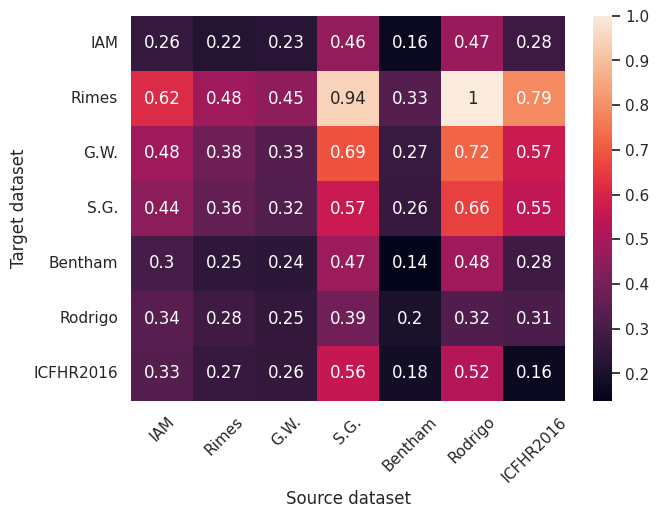

In [18]:
# Make a heatmap with the reconstruction errors for each source-target with reconstruction_errors dict
import seaborn as sns
import pandas as pd

# Set seaborn style
sns.set(style="whitegrid")

# Initialize the figure
plt.figure(figsize=(7, 5))

# Adjust the space between subplots
plt.subplots_adjust(hspace=5.)

# Plot the scatter plots with Seaborn's color palette
# Choose the palette with 6 different colors that can be easily distinguished
palette = sns.color_palette("rocket", as_cmap=True)

# Create a matrix with the reconstruction errors
reconstruction_errors_matrix = np.zeros((len(models.keys()), len(models.keys())))
for i, source in enumerate(models.keys()):
  for j, target in enumerate(models.keys()):
    reconstruction_errors_matrix[i, j] = reconstruction_errors[source][target]["all_errors"].mean()

# Save reconstruction_errors matrix as csv file
df = pd.DataFrame(reconstruction_errors_matrix, columns=models.keys(), index=models.keys())
df.to_csv("reconstruction_errors_matrix_raw.csv")


# Normalize the matrix
reconstruction_errors_matrix = reconstruction_errors_matrix / reconstruction_errors_matrix.max() 

labels = ['IAM', 'Rimes', 'G.W.', 'S.G.', 'Bentham', 'Rodrigo', 'ICFHR2016']
# Create a heatmap with the reconstruction errors
sns.heatmap(reconstruction_errors_matrix, annot=True, xticklabels=labels, yticklabels=labels) #cmap=sns.cubehelix_palette(as_cmap=True)) #, cmap='viridis')
# Change angle xticks
plt.xticks(rotation=45)
plt.xlabel("Source dataset")
plt.ylabel("Target dataset")

# Save image in pdf format
plt.savefig("reconstruction_errors_heatmap.pdf")

# Save reconstruction errors matrix as csv


df = pd.DataFrame(reconstruction_errors_matrix, columns=labels, index=labels)
df.to_csv("reconstruction_errors_matrix_normalized.csv")





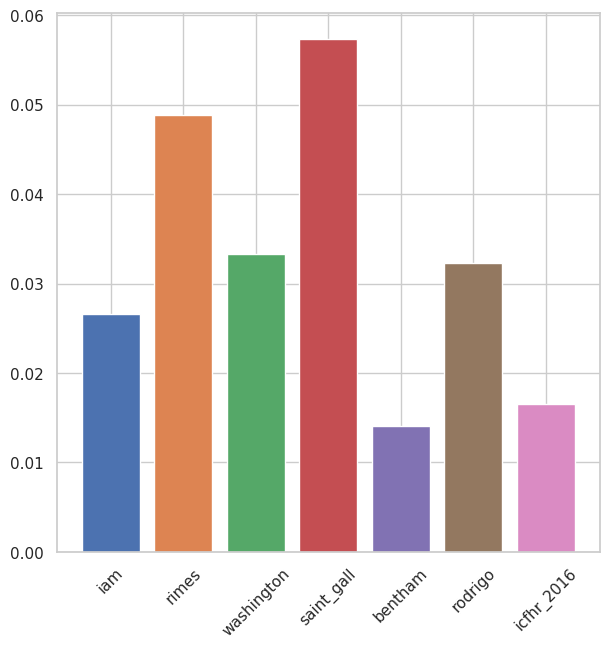

In [74]:
# Generate a barplot with the reconstruction errors differnces between ID datasets dict (get the mean) for each dataset with itself an its test dataset
# Set seaborn style
sns.set(style="whitegrid")

# Initialize the figure
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

for i, source in enumerate(models.keys()):
    ax.bar(source, reconstruction_errors[source][source]["all_errors"].mean())

ax.xaxis.set_tick_params(rotation=45)


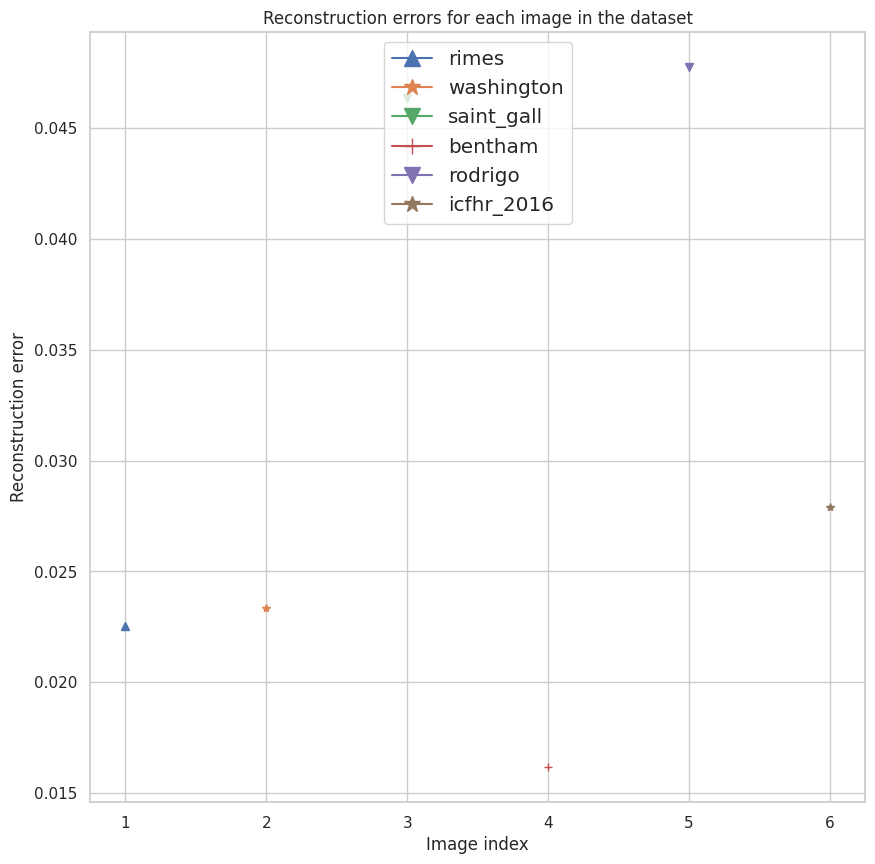

In [25]:
# Plot errors per images when source is IAM with reconstruction errors
!pip install seaborn
import seaborn as sns
# Set seaborn style
sns.set(style="whitegrid")

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for i, target in enumerate(reconstruction_errors['iam'].keys()):
    # Choose a random marker
    if target == 'iam':
        continue
    # Change opacity to see better the points
    # ax.scatter(range(len(reconstruction_errors['iam'][target]['all_errors'])), reconstruction_errors['iam'][target]['all_errors'], label=target, marker=np.random.choice(['o', 'x', '+', 'v', '^', '<', '>', 's', 'd', 'p', 'P', '*']), alpha=0.5)
    # ax.plot(i, reconstruction_errors['iam'][target]['total_loss'], label=target, marker=np.random.choice(['o', 'x', '+', 'v', '^', '<', '>', 's', 'd', 'p', 'P', '*']))
    ax.plot(i, reconstruction_errors['iam'][target]['all_errors'].mean(), label=target, marker=np.random.choice(['o', 'x', '+', 'v', '^', '<', '>', 's', 'd', 'p', 'P', '*']))
  # Change marker size
#   ax.set_title(f'IAM: reconstruction error: {round(reconstruction_errors["iam"][target]["reconstruction_error"], 3)}. % With respect IAM: {round(reconstruction_errors["iam"][target]["reconstruction_error"] / reconstruction_errors["iam"]["iam"]["reconstruction_error"], 3)}', fontsize=50)

# Set titles and labels gigantic
plt.title("Reconstruction errors for each image in the dataset")
plt.xlabel("Image index")
plt.ylabel("Reconstruction error")
plt.legend(loc='upper center', fontsize='large', markerscale=2)
plt.show()
# Save image in pdf format
# plt.savefig("reconstruction_errors.pdf")



{'iam': {'dataset': 'iam', 'total_loss': 1.221078673377633, 'reconstruction_error': 0.0004188949136801486, 'all_errors': array([0.02674619, 0.01849102, 0.02765321, ..., 0.02201512, 0.00832131,
       0.01518658]), 'n_samples': 2915}, 'rimes': {'dataset': 'iam', 'total_loss': 0.2920246981084347, 'reconstruction_error': 0.000375353082401587, 'all_errors': array([0.01827803, 0.01901617, 0.01115   , 0.01402673, 0.00842342,
       0.02391352, 0.01353673, 0.03087307, 0.02645942, 0.02308222,
       0.01832404, 0.02330475, 0.02100061, 0.01252424, 0.02720394,
       0.0195061 , 0.03699141, 0.01336167, 0.00875892, 0.03840216,
       0.02600936, 0.02151763, 0.02309012, 0.02341997, 0.0122998 ,
       0.01893752, 0.02487506, 0.03085561, 0.00817409, 0.01573866,
       0.03296289, 0.02503185, 0.03217805, 0.01102867, 0.05599954,
       0.03285284, 0.03653498, 0.01625273, 0.01470546, 0.03113906,
       0.01023867, 0.01325592, 0.00988337, 0.00844546, 0.01615185,
       0.01283693, 0.04031464, 0.02003041

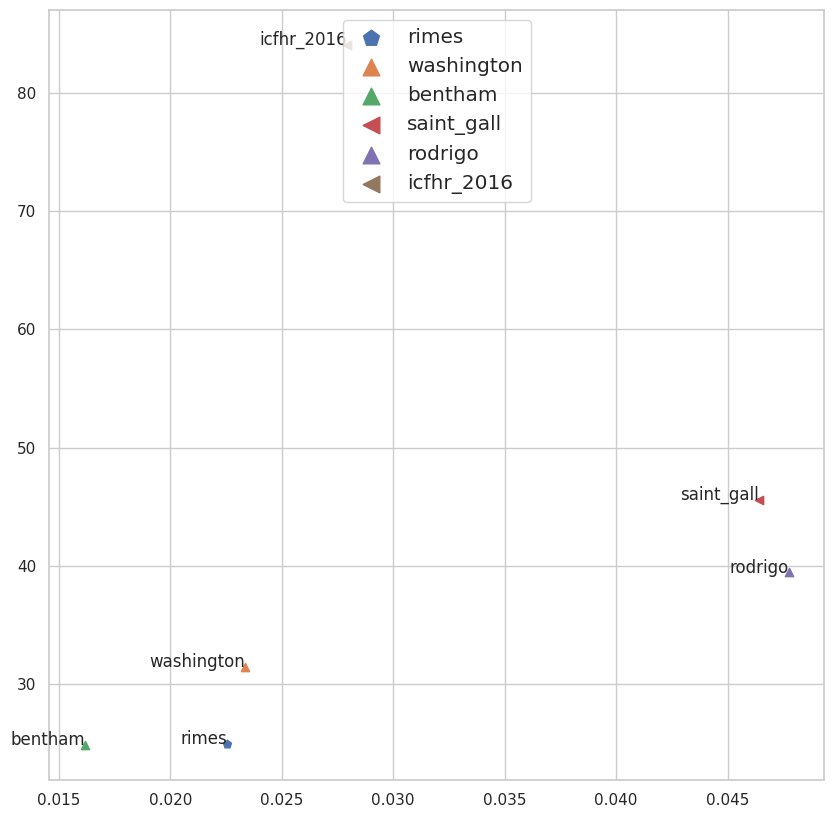

In [76]:
# Dataset	Puigcerver	
# 	ID	OOD
# IAM	6.4	34.9
# Rimes	3.7	25.0
# G.W.	8.2	31.1
# Bentham	4.7	25.3
# S.G.	7.2	33.6
# Rodrigo	1.7	40.9
# ICFHR$_{2016}$	5.2	78.8
# Average	5.3	38.5

# Convert the table to a dictionary
cer_puig = {
  "iam": (6.4, 34.9),
  "rimes": (3.7, 24.98),
  "washington": (8.2, 31.1),
  "bentham": (4.7, 25.3),
  "saint_gall": (7.2, 33.6),
  "rodrigo": (1.7, 40.9),
  "icfhr_2016": (5.2, 78.7)
}

# test_cers_ood = {
#   "washington": (0.3146, np.mean(error_images_washington)),
#   "saint_gall": (0.456, np.mean(error_images_saint_gall)),
#   "rimes": (0.2498, np.mean(error_images_rimes)),
#   "bentham": (0.2487, np.mean(error_images_bentham)),
#   "icfhr_2016": (0.8404, np.mean(error_images_icfhr2016)),
#   "rodrigo":(0.3944, np.mean(error_images_rodrigo))
# }


# Plot the CER (second value) vs Reconstruction error for each dataset
plt.figure(figsize=(10, 10))



# Plot CER in OOD vs Reconstruction error (from reconstruction_errors["iam"]
source_dataset = "iam"
print(reconstruction_errors[source_dataset])

for dataset, (cer, error) in cer_puig.items():
    if dataset == source_dataset:
        continue
    
    print(reconstruction_errors[source_dataset][dataset]["total_loss"], error, dataset)

    # plt.scatter(reconstruction_errors[source_dataset][dataset]["total_loss"], error, marker=np.random.choice(['o', 'x', '+', 'v', '^', '<', '>', 's', 'd', 'p', 'P', '*']), label=dataset)
    plt.scatter(reconstruction_errors[source_dataset][dataset]["all_errors"].mean(), error, marker=np.random.choice(['o', 'x', '+', 'v', '^', '<', '>', 's', 'd', 'p', 'P', '*']), label=dataset)
    plt.text(reconstruction_errors[source_dataset][dataset]["all_errors"].mean(), error, dataset, fontsize=12, ha='right')
    # plt.text(error, reconstruction_errors["iam"][dataset]["all_errors"].sum(), dataset, fontsize=12, ha='right')
# plt.scatter([v[1] for k, v in cer_puig.items()], [reconstruction_errors["iam"][k]["all_errors"].sum() for k, v in cer_puig.items()], marker='o')
plt.legend(loc='upper center', fontsize='large', markerscale=2)

AE(
  (encoder): Encoder(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (relu): LeakyReLU(negative_slope=0.01)
    (fc): Linear(in_features=32768, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=512, out_features=32768, bias=True)
    (deconv1): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (deconv2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (deconv3): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (deconv4): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): LeakyR

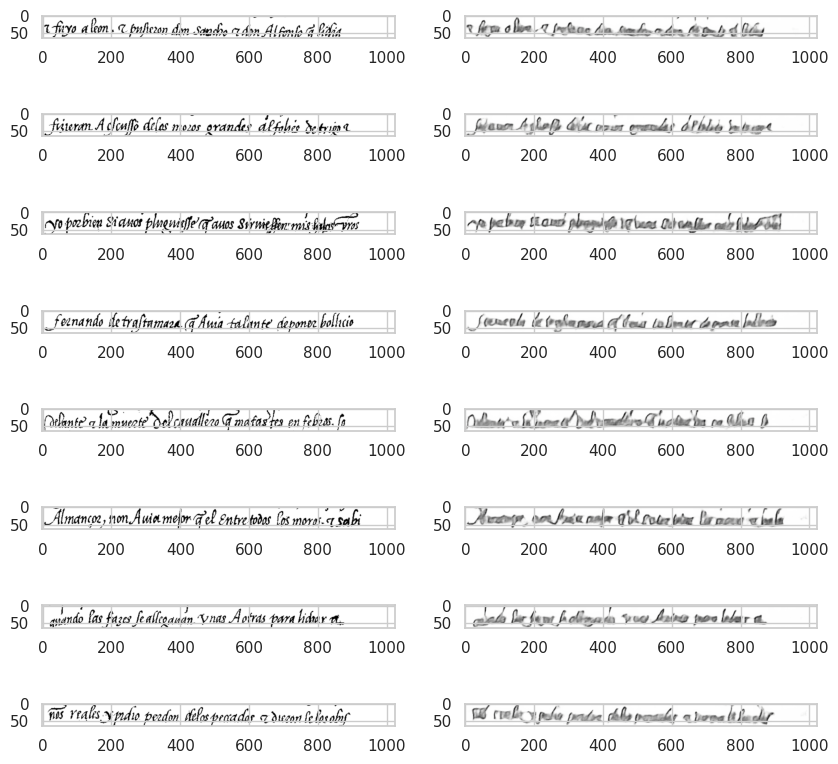

In [23]:
# Reconstruct some images from IAM dataset

# model_iam = trained_models['iam']
# model_iam.eval()

model_iam = AE()
model_iam.load_state_dict(torch.load('./checkpoints/best_ae_iam.ckpt'))
print(model)

# Get some images from IAM dataset
# dl_iam = train_datasets['iam']
# images = next(iter(dl_iam))
dl_test = test_datasets['rodrigo']
images = next(iter(dl_test))

print(len(images))

fig, ax = plt.subplots(len(images)//8, 2, figsize=(10, 10))

# Reconstruct images
with torch.no_grad():
    model_iam.eval()
    model_iam.to(device)
    images = images.to(device)
    outputs = model_iam(images) 

for i in range(len(images)//8):
    ax[i, 0].imshow(images[i].detach().cpu().permute(1, 2, 0))
    ax[i, 1].imshow(outputs[i].detach().cpu().permute(1, 2, 0))

# Plot the scatter plots with Seaborn's color palette
